In [23]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import torch
import torch.nn as nn

from skimage import io
from skimage.transform import resize
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

random_state = 42
gen = random.Random(random_state)

trimmed = True
data_dir = '../../allwavs/allvowl/corrected/extracted/' + 'trimmed/'*trimmed + 'img/'
files = os.listdir(data_dir)
use_mel = True
files = [file for file in files if ('mel' in file) == use_mel]
#max_w = max(io.imread(data_dir + '/' + file).shape[1] for file in tqdm(files))
#print(max_w)
max_w = 31 if not trimmed else 20# Measured
gen.shuffle(files)

In [24]:
def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight.data)
        m.bias.data.fill_(0.01)
    return

In [25]:
class SpectrumDataset(Dataset):
    def __init__(self, data_dir, files):
        self.data_dir = data_dir
        self.files = [file for file in files if '~' not in file.split('__')[0]]
        gen.shuffle(self.files)
        self.idx2lbl = ['2', '9', 'a', 'E', 'e', 'i', 'o', 'O', 'u', 'y']
        self.lbl2idx = {label: i for i, label in enumerate(self.idx2lbl)}
        all_phonemes = ['l', 'm', 'p', 's', 't', 't1']
        self.data = []
        for file in tqdm(self.files):
            split = file.split('__')
        
            gender = split[1]
            phonemes = split[4].split('_')
            
            image = io.imread(self.data_dir + '/' + file, as_gray=True)
            image = resize(image, (image.shape[0], max_w), anti_aliasing=False)
            
            label = file.split('__')[0].replace('E+', 'e').replace('@', '2')
            
            self.data.append((
            (torch.tensor(image).float(),
             torch.tensor([gender == 'f', *[phonemes[0] == x for x in all_phonemes]])
            ), self.lbl2idx[label]))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

l = len(files)
train_size = 0.9
cutoff = int(l*train_size)

train_set = SpectrumDataset(data_dir, files[:cutoff])
test_set = SpectrumDataset(data_dir, files[cutoff:])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 412/412 [00:06<00:00, 67.10it/s]


tensor([[0.8294, 0.8294, 0.9431,  ..., 0.9196, 0.7588, 0.7588],
        [0.7578, 0.7578, 0.8618,  ..., 0.8539, 0.7343, 0.7343],
        [0.7039, 0.7039, 0.7941,  ..., 0.8275, 0.7255, 0.7255],
        ...,
        [0.3980, 0.3980, 0.4412,  ..., 0.4902, 0.5059, 0.5059],
        [0.4324, 0.4324, 0.4735,  ..., 0.5490, 0.5569, 0.5569],
        [0.4608, 0.4608, 0.5039,  ..., 0.5804, 0.5882, 0.5882]])
tensor([ True, False, False,  True, False, False, False])
6


Text(0.5, 1.0, '6')

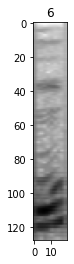

In [26]:
(im, features), label = train_set[0]
print(im)
print(features)
print(label)
plt.imshow(im.numpy(), cmap='gray')
plt.title(label)

In [27]:
class CNNClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNClassifier, self).__init__()
        
        self.cnn_layer1 = nn.Sequential(nn.Conv2d(1, 16, kernel_size=3, padding='valid'),
                                        nn.ReLU(),
                                        nn.Dropout(0.1),
                                        nn.BatchNorm2d(16),
                                        nn.MaxPool2d(kernel_size=2))
        self.cnn_layer2 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=3, padding='valid'),
                                        nn.ReLU(),
                                        nn.Dropout(0.2),
                                        nn.BatchNorm2d(32),
                                        nn.MaxPool2d(kernel_size=2))
        self.linear_layer1 = nn.Linear(32*30*3 + 7, 64)
        self.dropout1 = nn.Dropout(0.5)
        self.activ1 = nn.ReLU()
        self.linear_layer_p = nn.Linear(64, 32)
        self.dropout_p = nn.Dropout(0.5)
        self.activ_p = nn.ReLU()
        self.linear_layer2 = nn.Linear(32, num_classes)
        
    def forward(self, images, features):
        images = images.unsqueeze(1)
        
        cnn1 = self.cnn_layer1(images)
        cnn2 = self.cnn_layer2(cnn1)
        cnn_vec = cnn2.reshape(cnn2.shape[0], -1)
        cnn_cb = torch.cat((cnn_vec, features), dim=1)
        out = self.linear_layer1(cnn_cb)
        out = self.activ1(out)
        out = self.dropout1(out)
        out = self.linear_layer_p(out)
        out = self.dropout_p(out)
        out = self.activ_p(out)
        out2 = self.linear_layer2(out)
        return out2

In [32]:
def eval_cnn_classifier(model, eval_dataloader):
    model.eval() 
    with torch.no_grad():
        correct = 0
        total = 0
        for (images, features), labels in eval_dataloader:
            images = images.cuda()
            features = features.cuda()
            labels = labels.cuda()
            y_predicted = model(images, features)
            _, label_predicted = torch.max(y_predicted.data, 1)
            total += labels.size(0)
            correct += (label_predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

def training_cnn_classifier(model, train_dataloader, num_epochs, loss_fn, learning_rate, verbose=True):
    model_tr = copy.deepcopy(model)
    model_tr.train()
    optimizer = torch.optim.SGD(model_tr.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, 'min')
    loss_all_epochs = []
    test_acc_all_epochs = []

    if verbose:
        print(f'Epoch [0/{num_epochs}], Loss: N/A, Test acc: {eval_cnn_classifier(model_tr, test_dataloader):.4f}%')
    
    total = len(train_dataloader)
    for epoch in range(num_epochs):
        loss_current_epoch = 0
        for (images, features), labels in tqdm(train_dataloader, total=total):
            images = images.cuda()
            features = features.cuda()
            labels = labels.cuda()
            y_predicted = model_tr(images, features)
            loss = loss_fn(y_predicted, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_current_epoch += loss.item()
        
        loss_all_epochs.append(loss_current_epoch)
        test_acc = eval_cnn_classifier(model_tr, test_dataloader)
        test_acc_all_epochs.append(test_acc)
        if verbose:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss_current_epoch / total:.4f}, Test acc: {test_acc:.4f}%')
        if test_acc > 94.9:
            break
        
    return model_tr, loss_all_epochs, test_acc_all_epochs

Total number of parameters:  192138
Epoch [0/15], Loss: N/A, Test acc: 10.4369%


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 3559/3559 [00:08<00:00, 431.94it/s]


Epoch [1/15], Loss: 1.2807, Test acc: 78.8835%


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 3559/3559 [00:07<00:00, 445.51it/s]


Epoch [2/15], Loss: 0.5761, Test acc: 87.1359%


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 3559/3559 [00:07<00:00, 445.38it/s]


Epoch [3/15], Loss: 0.4271, Test acc: 89.8058%


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 3559/3559 [00:07<00:00, 445.80it/s]


Epoch [4/15], Loss: 0.3157, Test acc: 85.4369%


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 3559/3559 [00:08<00:00, 437.81it/s]


Epoch [5/15], Loss: 0.2659, Test acc: 90.0485%


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 3559/3559 [00:07<00:00, 445.25it/s]


Epoch [6/15], Loss: 0.2121, Test acc: 92.7184%


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 3559/3559 [00:09<00:00, 374.68it/s]


Epoch [7/15], Loss: 0.1608, Test acc: 92.7184%


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 3559/3559 [00:08<00:00, 436.27it/s]


Epoch [8/15], Loss: 0.1354, Test acc: 93.6893%


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 3559/3559 [00:08<00:00, 424.08it/s]


Epoch [9/15], Loss: 0.1319, Test acc: 95.1456%


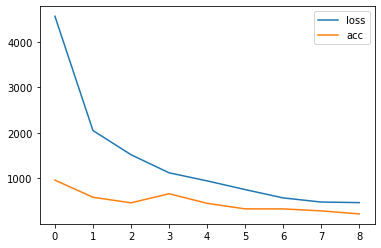

In [34]:
batch_size = 1
train_dataloader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_set, batch_size=batch_size)

num_classes = 10
model = CNNClassifier(num_classes)

print('Total number of parameters: ', 
      sum(p.numel() for p in model.parameters()))

torch.manual_seed(0)
model.apply(init_weights)

num_epochs = 15
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.01

model.cuda()
model, loss_total, test_acc_total = training_cnn_classifier(model, train_dataloader, num_epochs, loss_fn, learning_rate, verbose=True)

torch.save(model, 'model_cnn_classif.pt')
plt.plot(loss_total, label='loss')
plt.plot([max(loss_total)*(100-x)/100 for x in test_acc_total], label='acc')
plt.legend()
plt.show()

In [30]:
acc = eval_cnn_classifier(model, test_dataloader)
print(acc)

93.93203883495146


              precision    recall  f1-score   support

           2     0.9688    0.7750    0.8611        40
           9     0.7660    1.0000    0.8675        36
           a     0.9783    0.9574    0.9677        47
           E     0.9545    0.8400    0.8936        25
           e     0.9077    0.9672    0.9365        61
           i     1.0000    1.0000    1.0000        33
           O     0.9574    1.0000    0.9783        45
           o     0.9706    0.8919    0.9296        37
           u     1.0000    0.9778    0.9888        45
           y     0.9524    0.9302    0.9412        43

    accuracy                         0.9393       412
   macro avg     0.9456    0.9340    0.9364       412
weighted avg     0.9454    0.9393    0.9393       412



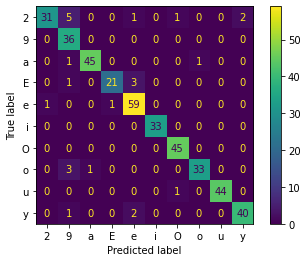

In [31]:
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    correct = 0
    total = 0
    for (images, features), labels in test_dataloader:
        images = images.cuda()
        features = features.cuda()
        labels = labels.cuda()
        y_predicted = model(images, features)
        _, label_predicted = torch.max(y_predicted.data, 1)
        y_pred.append(label_predicted.item())
        y_true.append(labels.item())

        
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
target_names = ['2', '9', 'a', 'E', 'e', 'i', 'O', 'o', 'u', 'y']
print(classification_report(y_true, y_pred, zero_division=0, digits=4, target_names=target_names))
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot()